In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Оценка качества модели
from sklearn.metrics import mean_squared_error

In [2]:
# Определение полиномиальных моделей
polynomial_models = [
    'PolynomialMemoryModel',
    'SparseDelayMemoryPolynomialModel',
    'OrthogonalMemoryPolynomialModel',
    'NonUniformMemoryPolynomialModel',
    'HybridMemoryPolynomialModel',
    'GeneralizedMemoryPolynomialModel',
    'ExponentiallyShapedMemoryDelayProfileModel',
    'EnvelopeMemoryPolynomialModel'
]

In [3]:
# Карта параметров для каждой модели
model_parameters = {
    'SparseDelayMemoryPolynomialModel': ['K', 'M', 'M_SD'],
    'PolynomialMemoryModel': ['K', 'M'],
    'OrthogonalMemoryPolynomialModel': ['K', 'M'],
    'NonUniformMemoryPolynomialModel': ['M', 'K_list'],
    'HybridMemoryPolynomialModel': ['K', 'M', 'K_e', 'M_e'],
    'GeneralizedMemoryPolynomialModel': ['K_a', 'M_a', 'K_b', 'M_b', 'P', 'K_c', 'M_c', 'Q'],
    'ExponentiallyShapedMemoryDelayProfileModel': ['K', 'M', 'delta_0', 'alpha'],
    'EnvelopeMemoryPolynomialModel': ['K', 'M'],
    'DDRVolterraModel': ['K', 'M']
}

In [4]:
# Путь к файлу логов
log_file_path = 'TypePolynomialModelC/logs_copy.txt'

In [5]:
def parse_logs(log_file_path, model_parameters):
    # Обновлённое регулярное выражение
    pattern = re.compile(
        r"^(?P<model_name>\w+MemoryPolynomialModel|DDRVolterraModel|ExponentiallyShapedMemoryDelayProfileModel|PolynomialMemoryModel)\s+(?P<params>[\d\.\s]+)\n"  # Имя модели и параметры (включая плавающие числа)
        r"RMSE \(Real part\): (?P<rmse_real>[\d\.\-e]+), RMSE \(Imaginary part\): (?P<rmse_imag>[\d\.\-e]+)\n"
        r"(?:\n)?"  # Пустая строка
        r"real\s+(?P<real_min>\d+)m(?P<real_sec>[\d,\.]+)s\n"
        r"user\s+(?P<user_min>\d+)m(?P<user_sec>[\d,\.]+)s\n"
        r"sys\s+(?P<sys_min>\d+)m(?P<sys_sec>[\d,\.]+)s",
        re.MULTILINE
    )

    # Чтение лог-файла
    with open(log_file_path, 'r', encoding='utf-8') as file:
        log_content = file.read()

    # Поиск и извлечение совпадений
    matches = pattern.finditer(log_content)

    # Подготовка данных для DataFrame
    data = []
    for match in matches:
        model_name = match.group("model_name")
        params = match.group("params").split()
        rmse_real = match.group("rmse_real")
        rmse_imag = match.group("rmse_imag")
        real_min = match.group("real_min")
        real_sec = match.group("real_sec")
        user_min = match.group("user_min")
        user_sec = match.group("user_sec")
        sys_min = match.group("sys_min")
        sys_sec = match.group("sys_sec")

        # Конвертация параметров модели в числа
        params = [float(x) for x in params] if params else []
        expected_params = model_parameters.get(model_name, [])
        
        # Обработка параметров модели, особая для NonUniformMemoryPolynomialModel
        if model_name == 'NonUniformMemoryPolynomialModel':
            m_value = params[0] if len(params) > 0 else np.nan
            k_list_value = params[1:] if len(params) > 1 else np.nan
            param_dict = {'M': m_value, 'K_list': k_list_value}
        else:
            param_dict = {param: (params[idx] if idx < len(params) else np.nan) for idx, param in enumerate(expected_params)}

        # Преобразование времени из минут и секунд в секунды
        real_time = int(real_min) * 60 + float(real_sec.replace(',', '.'))
        user_time = int(user_min) * 60 + float(user_sec.replace(',', '.'))
        sys_time = int(sys_min) * 60 + float(sys_sec.replace(',', '.'))
        
        entry = {
            'Model Name': model_name,
            'RMSE Real': float(rmse_real),
            'RMSE Imag': float(rmse_imag),
            'Real Time (s)': real_time,
            'User Time (s)': user_time,
            'Sys Time (s)': sys_time,
            **param_dict  # Включение параметров модели
        }
        data.append(entry)

    # Создание DataFrame
    df = pd.DataFrame(data)
    df.to_csv('TypePolynomialModelC/logs_summary.csv', index=False)
    return df

In [6]:
df = parse_logs(log_file_path, model_parameters)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model Name     66 non-null     object 
 1   RMSE Real      66 non-null     float64
 2   RMSE Imag      66 non-null     float64
 3   Real Time (s)  66 non-null     float64
 4   User Time (s)  66 non-null     float64
 5   Sys Time (s)   66 non-null     float64
 6   K              48 non-null     float64
 7   M              53 non-null     float64
 8   M_SD           11 non-null     float64
 9   K_list         5 non-null      object 
 10  K_e            11 non-null     float64
 11  M_e            11 non-null     float64
 12  K_a            13 non-null     float64
 13  M_a            13 non-null     float64
 14  K_b            13 non-null     float64
 15  M_b            13 non-null     float64
 16  P              13 non-null     float64
 17  K_c            13 non-null     float64
 18  M_c         

In [7]:
df.head()

,Model Name,RMSE Real,RMSE Imag,Real Time (s),User Time (s),Sys Time (s),K,M,M_SD,K_list,...,K_a,M_a,K_b,M_b,P,K_c,M_c,Q,delta_0,alpha
0,PolynomialMemoryModel,0.206405,0.207271,1.084,1.039,0.045,3.0,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,PolynomialMemoryModel,0.108151,0.108143,1.971,1.868,0.103,5.0,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PolynomialMemoryModel,0.093029,0.092957,8.211,7.856,0.351,10.0,10.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PolynomialMemoryModel,0.092296,0.092222,28.492,27.785,0.705,15.0,15.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PolynomialMemoryModel,0.092639,0.092589,239.462,236.675,2.720,20.0,20.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def plot_rmse_trends(df, models, rmse_limit=None, print_annotate=False):
    # График для RMSE Real
    plt.figure(figsize=(12, 6))
    
    for model in models:
        df_model = df[df['Model Name'] == model]
        if rmse_limit is not None:
            df_model = df_model[df_model['RMSE Real'] < rmse_limit]
        
        plt.plot(df_model.index, df_model['RMSE Real'], marker='o', linestyle='-', label=model)

        if not df_model.empty:
            min_real_index = df_model['RMSE Real'].idxmin()
            min_real_value = df_model.loc[min_real_index, 'RMSE Real']

            if print_annotate: plt.annotate(f'{min_real_value:.4f}', 
                         (min_real_index, min_real_value), 
                         textcoords="offset points", 
                         xytext=(-15, -10), 
                         ha='center', 
                         fontsize=8, 
                         weight='bold', 
                         color='red')

    plt.title('Trends of RMSE (Real Part) for Polynomial Models')
    plt.xlabel('Stage (Index)')
    plt.ylabel('RMSE (Real Part)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # График для RMSE Imaginary
    plt.figure(figsize=(12, 6))
    
    for model in models:
        df_model = df[df['Model Name'] == model]
        if rmse_limit is not None:
            df_model = df_model[df_model['RMSE Imag'] < rmse_limit]
        
        plt.plot(df_model.index, df_model['RMSE Imag'], marker='o', linestyle='-', label=model)

        if not df_model.empty:
            min_imag_index = df_model['RMSE Imag'].idxmin()
            min_imag_value = df_model.loc[min_imag_index, 'RMSE Imag']

            if print_annotate: plt.annotate(f'{min_imag_value:.4f}', 
                         (min_imag_index, min_imag_value), 
                         textcoords="offset points", 
                         xytext=(-15, -10), 
                         ha='center', 
                         fontsize=8, 
                         weight='bold', 
                         color='blue')

    plt.title('Trends of RMSE (Imaginary Part) for Polynomial Models')
    plt.xlabel('Stage (Index)')
    plt.ylabel('RMSE (Imaginary Part)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

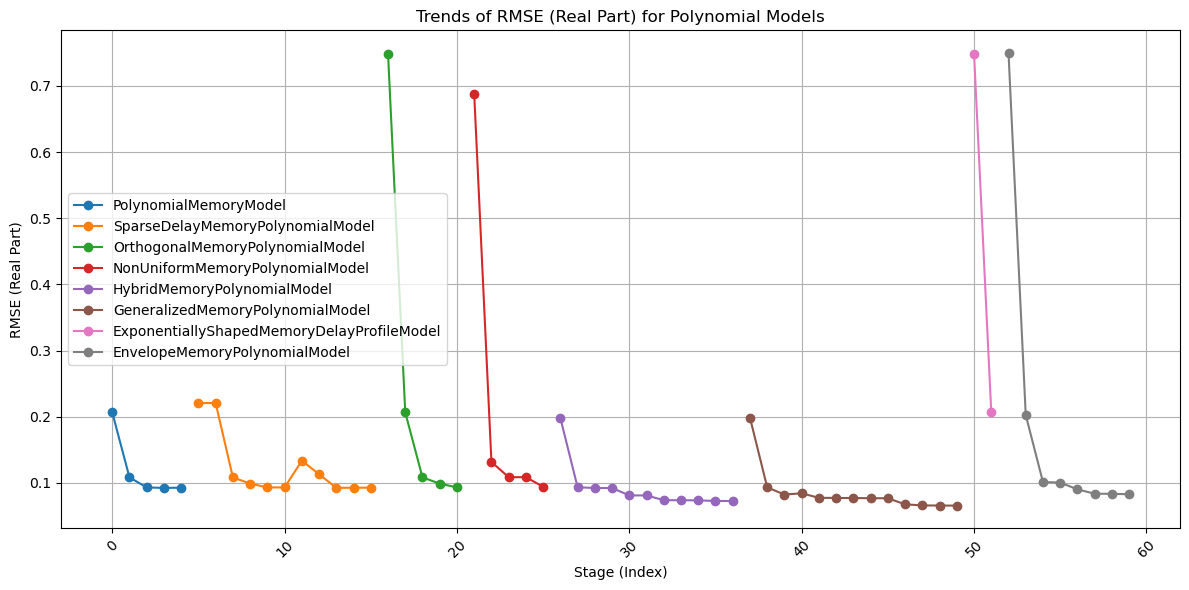

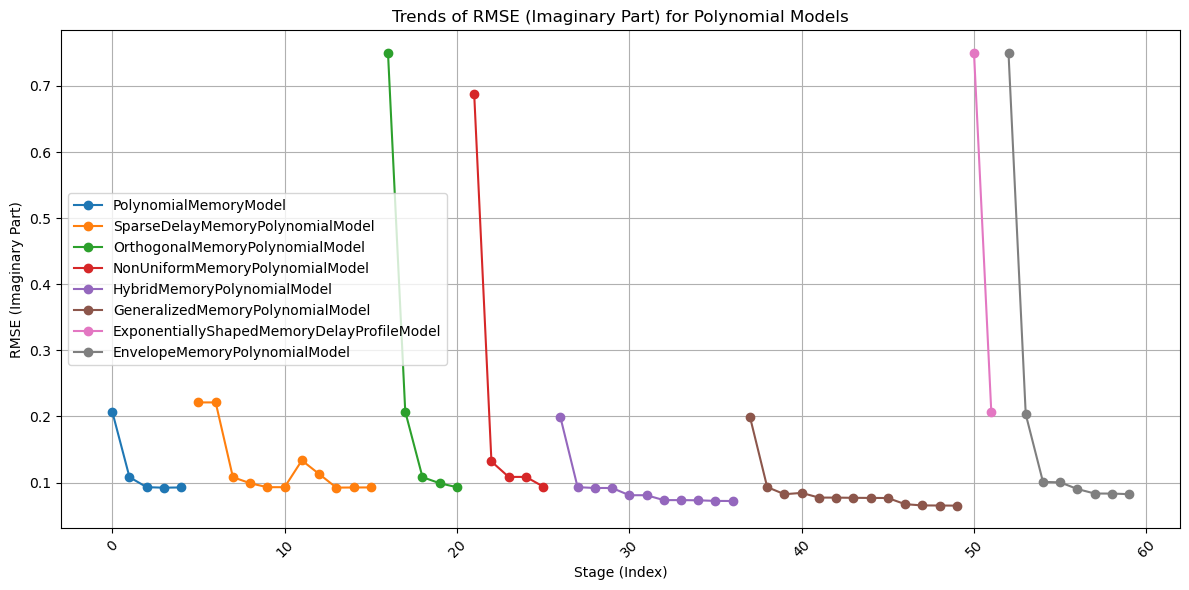

In [9]:
plot_rmse_trends(df, polynomial_models)

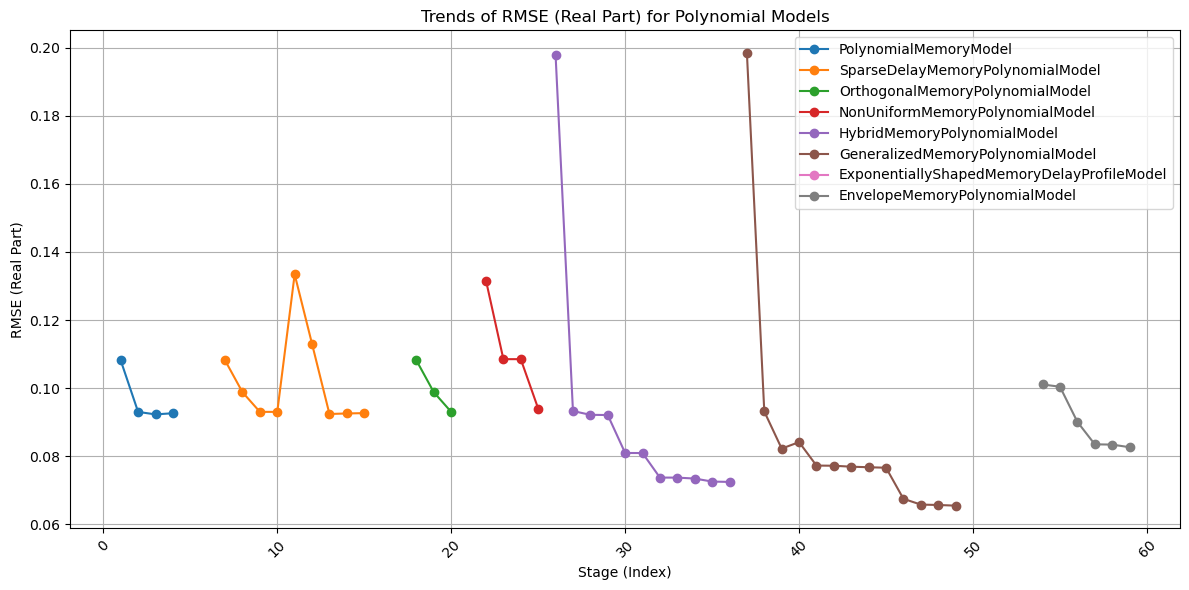

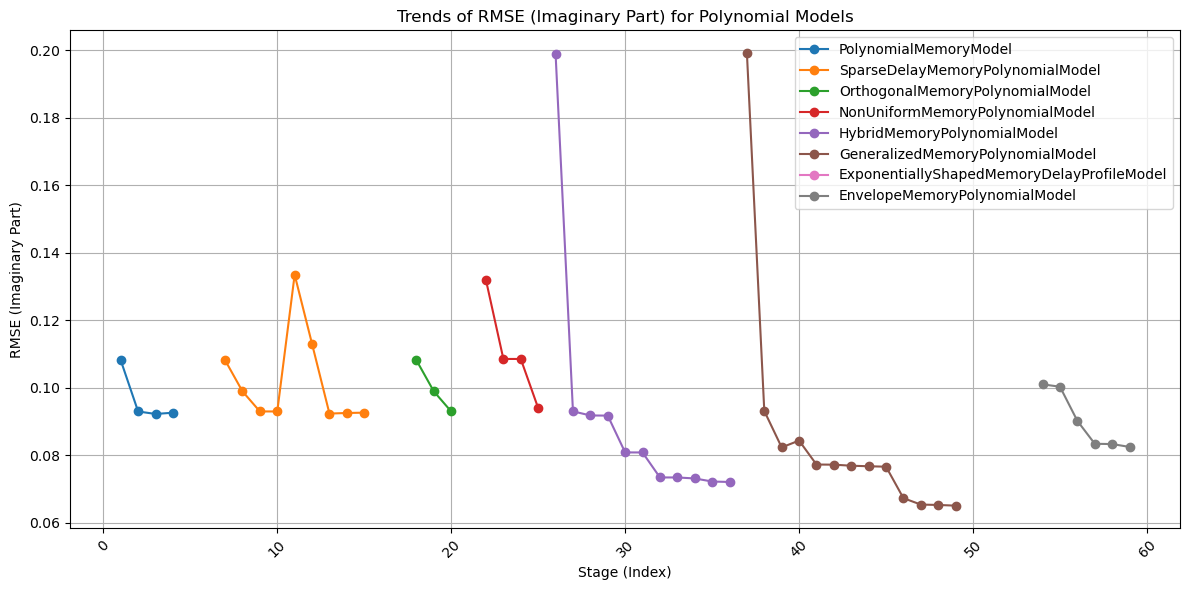

In [10]:
plot_rmse_trends(df, polynomial_models, rmse_limit=0.2)

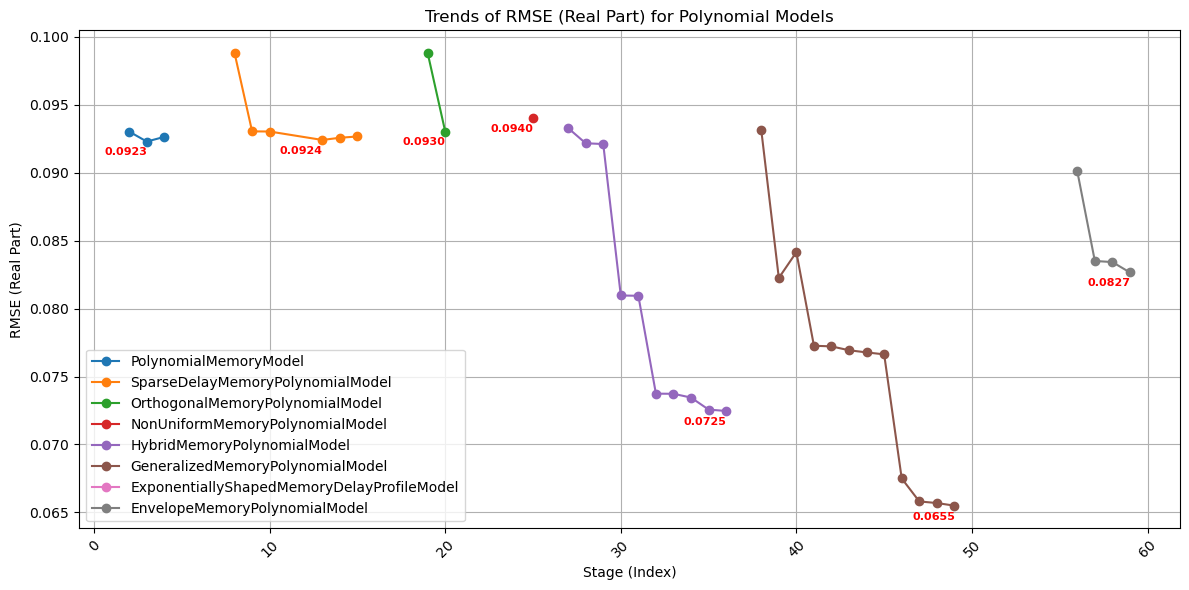

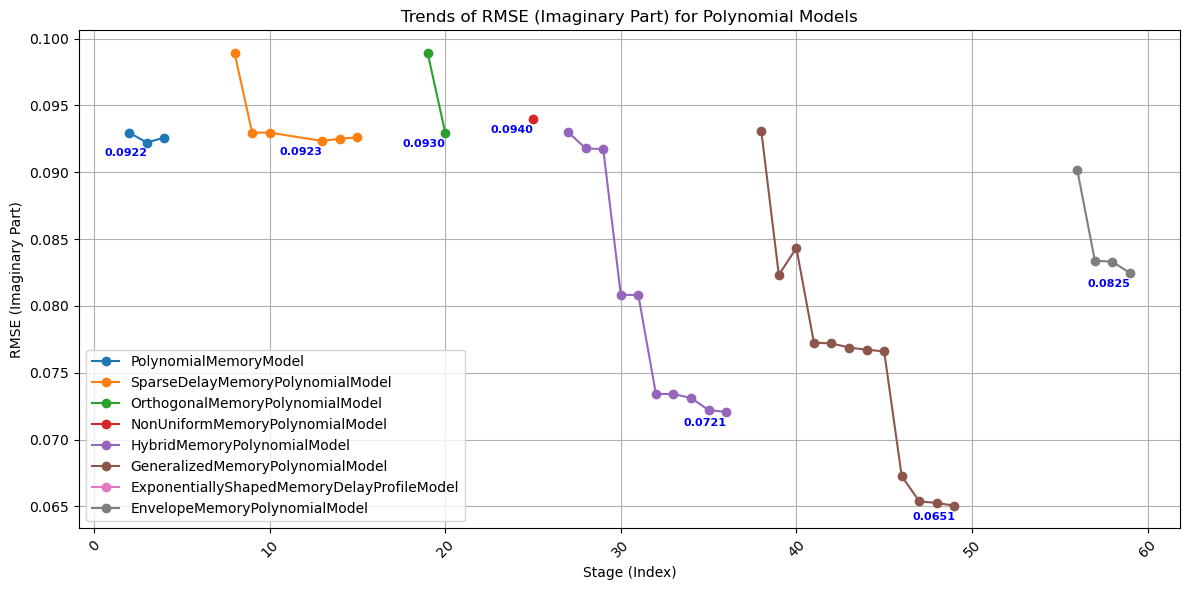

In [11]:
plot_rmse_trends(df, polynomial_models, rmse_limit=0.1, print_annotate=True)

In [12]:
def get_min_rmse_table(df, models, model_parameters):
    min_rmse_data = []

    for model in models:
        df_model = df[df['Model Name'] == model]

        if not df_model.empty:
            min_rmse_real = df_model['RMSE Real'].min()
            min_rmse_imag = df_model['RMSE Imag'].min()
            min_rmse_real_idx = df_model['RMSE Real'].idxmin()

            param_keys = model_parameters.get(model, [])
            hyperparameters_real = {}
            
            # Извлечение времени выполнения
            execution_time = df_model.loc[min_rmse_real_idx, ['Real Time (s)', 'User Time (s)', 'Sys Time (s)']].mean()

            for param in param_keys:
                value = df_model.loc[min_rmse_real_idx, param]

                # Проверяем наличие NaN для скалярных значений и массивов
                if isinstance(value, (list, np.ndarray)):
                    if not all(pd.isna(v) for v in value):  # Проверяем все элементы на NaN
                        hyperparameters_real[param] = value  # Прямо используем значение, если это список
                else:
                    if not pd.isna(value):  # Проверяем значение, если это не массив
                        hyperparameters_real[param] = value

            min_rmse_data.append({
                "Model Name": model,
                "Min RMSE Real": min_rmse_real,
                "Min RMSE Imag": min_rmse_imag,
                "Execution Time (s)": execution_time,
                "Hyperparameters": hyperparameters_real
            })

    min_rmse_df = pd.DataFrame(min_rmse_data)
    min_rmse_df = min_rmse_df.sort_values(by=["Min RMSE Real", "Min RMSE Imag"]).reset_index(drop=True)
    min_rmse_df.to_csv("TypePolynomialModelC/min_rmse_summary.csv", index=False)

    return min_rmse_df

In [13]:
get_min_rmse_table(df, polynomial_models, model_parameters)

,Model Name,Min RMSE Real,Min RMSE Imag,Execution Time (s),Hyperparameters
0,GeneralizedMemoryPolynomialModel,0.065500,0.065056,111.924333,"{'K_a': 18.0, 'M_a': 18.0, 'K_b': 5.0, 'M_b': ..."
1,HybridMemoryPolynomialModel,0.072467,0.072067,38.096333,"{'K': 15.0, 'M': 15.0, 'K_e': 10.0, 'M_e': 10.0}"
2,EnvelopeMemoryPolynomialModel,0.082659,0.082452,89.546667,"{'K': 15.0, 'M': 15.0}"
3,PolynomialMemoryModel,0.092296,0.092222,18.994000,"{'K': 15.0, 'M': 15.0}"
4,SparseDelayMemoryPolynomialModel,0.092412,0.092337,18.722000,"{'K': 13.0, 'M': 13.0, 'M_SD': 10.0}"
5,OrthogonalMemoryPolynomialModel,0.093029,0.092957,77.215000,"{'K': 10.0, 'M': 10.0}"
6,NonUniformMemoryPolynomialModel,0.094015,0.093976,1.582667,"{'M': 10.0, 'K_list': [8.0, 7.0, 5.0, 4.0, 3.0..."
7,ExponentiallyShapedMemoryDelayProfileModel,0.206468,0.207344,4932.520333,"{'K': 3.0, 'M': 2.0, 'delta_0': 2.0, 'alpha': ..."
